In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
%matplotlib notebook

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [6]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    # Define values
    x = np.linspace(a,b,n+1)
    y = np.linspace(c,d,n+1)
    h = x[1] - x[0]
    p = 1 / h**2 * np.hstack([[g(x[0],yj)] + [0] * (n-3) + [g(x[-1],yj)] for yj in y[1:-1]])
    q = 1 / h**2 * np.array([g(xi,y[0]) for xi in x[1:-1]] + [0] * (n-1) * (n-3) + [g(xi,y[-1]) for xi in x[1:-1]])
    f_vec = np.hstack([[f(xi,yj) for xi in x[1:-1]] for yj in y[1:-1]])
    T = sp.diags([-4,1,1],[0,1,-1],((n-1),(n-1)))
    A = 1 / h**2 * (sp.block_diag([T] * (n-1)) +  sp.diags([1,1],[(n-1),-(n-1)],((n-1)**2,(n-1)**2),format='csr'))

    # Solve for U
    U = spla.spsolve(A,f_vec-p-q)
    
    # Reshape back to matrix form
    U = U.reshape(99,99)
    
    # Add in boundary values 
    left = g(a, y[1:-1])
    right = g(b, y[1:-1])
    top = g(x,d)
    bottom = g(x,c)
    U = np.column_stack((left, U, right))
    U = np.vstack((top, U, bottom))
    
    return U 

(101, 101) (101, 101)


<IPython.core.display.Javascript object>


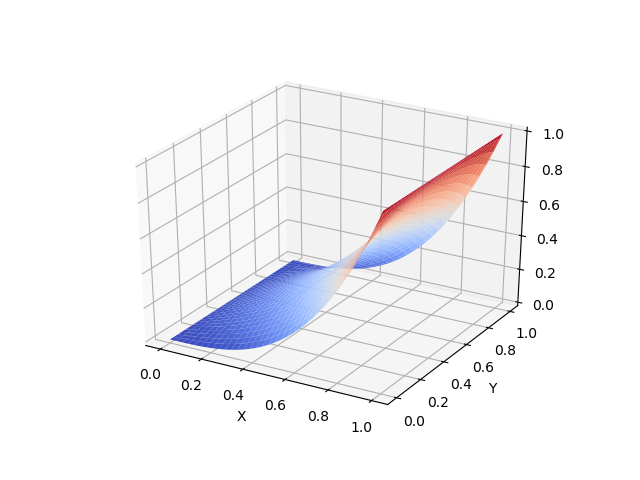

In [28]:
# Solve the poisson equation
U = poisson_square(0,1,0,1,lambda x,y : x * 0  + y * 0, lambda x,y : x**3 + y * 0,100 )

X = np.linspace(0,1,101)
Y = np.linspace(0,1,101)
X,Y = np.meshgrid(X,Y)

print(X.shape, U.shape)
# Create a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,U,cmap="coolwarm")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

In [13]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

plt.imshow(source(X,Y),cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))))
plt.colorbar(label="Relative Charge")
plt.show()

<IPython.core.display.Javascript object>


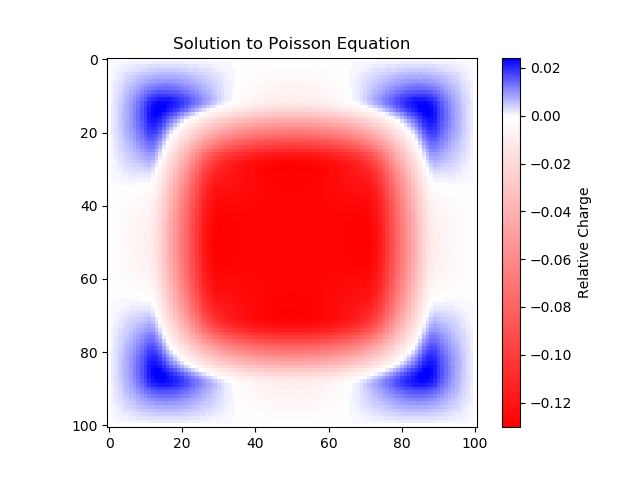

In [14]:
U = poisson_square(a1,b1,c1,d1,lambda x,y : -source(x,y) ,lambda x, y : x * 0 + y * 0,100)

plt.imshow(U,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(U)))
plt.title("Solution to Poisson Equation")
plt.colorbar(label="Relative Charge")
plt.show()
